<a href="https://colab.research.google.com/github/bintangnabiil/Deep_Learning/blob/main/Deep_Learning_RNN_Model_Week_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1) RNN PyTorch

##1. Preprocessing Data


In [1]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import re
from collections import Counter

# Upload file di Colab manual: File > Upload to session storage
df = pd.read_csv('/content/ReviewTokoBaju.csv')  # Ganti sesuai lokasi file jika perlu

# Bersihkan data
df = df.dropna(subset=["Review Text", "Recommended IND"])
texts = df["Review Text"].astype(str).tolist()
labels = df["Recommended IND"].astype(int).tolist()

# Tokenisasi sederhana
def tokenize(text):
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    return text.lower().split()

tokenized_texts = [tokenize(t) for t in texts]

# Bangun vocab
all_words = [word for tokens in tokenized_texts for word in tokens]
vocab = {word: idx+2 for idx, (word, _) in enumerate(Counter(all_words).items())}
vocab['<PAD>'] = 0
vocab['<UNK>'] = 1

# Encode dan pad
MAX_LEN = 100
def encode_pad(tokens):
    encoded = [vocab.get(token, vocab['<UNK>']) for token in tokens]
    return encoded[:MAX_LEN] + [0] * (MAX_LEN - len(encoded))

X = torch.tensor([encode_pad(t) for t in tokenized_texts])
y = torch.tensor(labels).float()

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

class ReviewDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

train_loader = DataLoader(ReviewDataset(X_train, y_train), batch_size=64, shuffle=True)
test_loader = DataLoader(ReviewDataset(X_test, y_test), batch_size=64)

##2. Mendefinisikan Model RNN PyTorch

In [2]:
class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim=100, hidden_dim=128):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.rnn = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        emb = self.embedding(x)
        _, h = self.rnn(emb)
        out = self.fc(h.squeeze(0))
        return self.sigmoid(out)

##3. Training Model

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RNNClassifier(len(vocab)).to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training
for epoch in range(5):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb).squeeze()
        loss = loss_fn(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} Loss: {total_loss:.4f}")

Epoch 1 Loss: 135.7002
Epoch 2 Loss: 104.6731
Epoch 3 Loss: 71.1580
Epoch 4 Loss: 56.3001
Epoch 5 Loss: 45.9961


##4. Evaluasi Sederhana

In [4]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        preds = model(xb).squeeze().cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(yb.numpy())

# Konversi prediksi ke 0/1
preds_bin = [1 if p > 0.5 else 0 for p in all_preds]
accuracy = accuracy_score(all_labels, preds_bin)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.8794


#2) RNN Tensorflow

##1. Import dan Preprocessing

In [11]:
import pandas as pd
import re
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Baca file yang di-upload ke session storage
df = pd.read_csv('/content/ReviewTokoBaju.csv')
df = df.dropna(subset=['Review Text', 'Recommended IND'])

texts = df['Review Text'].astype(str).tolist()
labels = df['Recommended IND'].astype(int).tolist()

# Bersihkan teks
def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text.lower()

texts = [clean_text(t) for t in texts]

# Tokenisasi dan vektorisasi
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# Padding
MAX_LEN = 100
X = pad_sequences(sequences, maxlen=MAX_LEN, padding='post')
y = np.array(labels)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##2. Bangun Model RNN TensorFlow


In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

model = Sequential([
    Embedding(input_dim=10000, output_dim=100),  # input_length dihapus karena sudah deprecated
    SimpleRNN(128),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.build(input_shape=(None, MAX_LEN))
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 100, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_4 (SimpleRNN)        │ (None, 128)            │        29,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,029,441 (3.93 MB)

 Trainable params: 1,029,441 (3.93 MB)

 Non-trainable params: 0 (0.00 B)

##3. Training Model

In [16]:
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.1)

Epoch 1/5
255/255 ━━━━━━━━━━━━━━━━━━━━ 22s 77ms/step - accuracy: 0.8076 - loss: 0.4811 - val_accuracy: 0.7975 - val_loss: 0.5114
Epoch 2/5
255/255 ━━━━━━━━━━━━━━━━━━━━ 18s 66ms/step - accuracy: 0.8183 - loss: 0.4750 - val_accuracy: 0.7975 - val_loss: 0.5112
Epoch 3/5
255/255 ━━━━━━━━━━━━━━━━━━━━ 22s 71ms/step - accuracy: 0.8184 - loss: 0.4744 - val_accuracy: 0.7958 - val_loss: 0.5067
Epoch 4/5
255/255 ━━━━━━━━━━━━━━━━━━━━ 19s 67ms/step - accuracy: 0.8226 - loss: 0.4698 - val_accuracy: 0.7919 - val_loss: 0.5154
Epoch 5/5
255/255 ━━━━━━━━━━━━━━━━━━━━ 21s 69ms/step - accuracy: 0.8280 - loss: 0.4495 - val_accuracy: 0.7908 - val_loss: 0.5305


##4. Evaluasi Akurasi di Test Set

In [17]:
loss, acc = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {acc:.4f}')

142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8064 - loss: 0.5013
Test Accuracy: 0.8108


#Evaluasi & ROC

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 1. Prediksi
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype("int32")

# 2. Hitung metriks evaluasi
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

print(f"Akurasi  : {acc:.4f}")
print(f"Presisi  : {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-Score : {f1:.4f}")
print(f"AUC      : {auc:.4f}")

142/142 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step
Akurasi  : 0.8108
Presisi  : 0.8205
Recall   : 0.9849
F1-Score : 0.8952
AUC      : 0.4981


##Plot ROC Curve

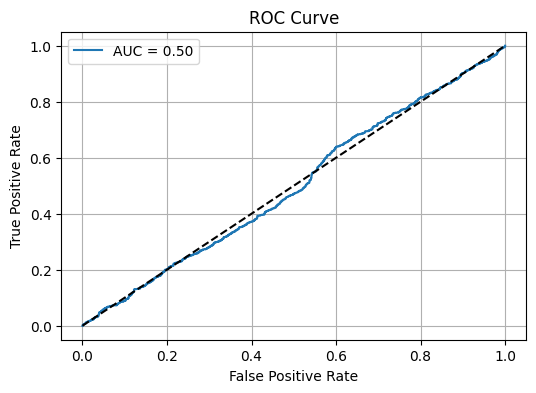

In [19]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

##Plot Akurasi dan Loss dari History

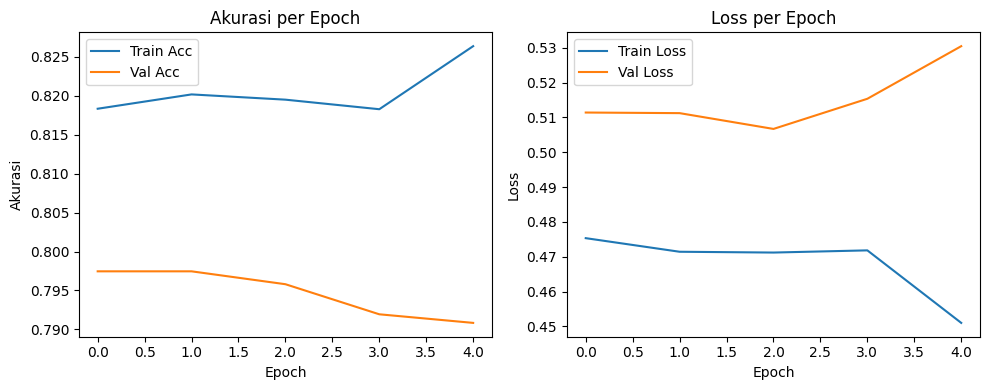

In [20]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Akurasi per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Akurasi")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

#Penjelasan Persamaan Matamtika
##1. Recurrent Neural Network (RNN)
RNN memproses urutan data (seperti kalimat) dengan mengulang operasi matematis di setiap langkah waktu (timestep). Di SimpleRNN, yang dihitung:
<br><br>
$$
h_t = tanh(W_{xh}x_t + W_{hh}h_{t-1} + b_h)
$$<br><br>

Keterangan:
- $x_t$ = input pada waktu ke-$t$(misalnya, kata ke-1, ke-2, dst.)
- $h_t$ = hidden state baru pada waktu ke-$t$
- $h_{t-1}$ = hidden state sebelumnya
- $W_{xh}$ = bobot dari input ke hidden
- $W_{hh}$ = bobot dari hidden ke hidden
- $b_h$ = bias
- $tanh$ = fungsi aktivasi untuk membuat output tetap dalam rentang [-1,1]<br><br>

##2. Dense Layer / Output Layer
Setelah semua input diproses oleh RNN, hidden state terakhir $h_T$ dikirim ke lapisan output:
<br><br>
$$
\hat{y} = \sigma(W_oh_t + b_o)
$$<br><br>

Keterangan:
- $\hat{y}$ = output prediksi (nilai antara 0–1)
- $W_o$ = bobot output
- $b_o$ = bias output
- $\sigma$ = fungsi sigmoid, digunakan untuk klasifikasi biner:

$$
\sigma(z) = \frac{1}{1+e^{-z}}
$$<br><br>

Hasil dari sigmoid digunakan untuk menentukan apakah prediksi adalah kelas 0 atau 1.<br><br>

##3. Fungsi Loss (Binary Crossentropy)
Karena ini klasifikasi biner, kita pakai fungsi loss:
<br><br>
$$
Loss = -[ylog(\hat{y}) + (1-y) log(1-\hat{y})]
$$<br><br>

Keterangan:
- $y$ = label asli (0 atau 1)
- $\hat{y}$ = prediksi dari model
- Jika prediksi dekat dengan label, loss-nya kecil.
- Kalau prediksi salah jauh dari label, loss-nya besar.<br><br>

##4. Optimisasi dengan Gradient Descent (Adam)
Selama training, model memperbarui bobot $W$ menggunakan rumus dari gradient descent, misalnya:
<br><br>
$$
W \leftarrow W - η ⋅ ∇_WLoss
$$<br><br>

Keterangan:
- $η$ = learning rate
- $∇_W$ = turunan (gradien) dari loss terhadap bobot $W$

Kita pakai optimizer Adam, yang menggabungkan momentum dan RMSProp untuk update bobot lebih cepat dan stabil.<br><br>

## 5. Akurasi
Akurasi cocok kalau datanya seimbang (jumlah kelas 0 dan 1 relatif sama).
<br><br>
$$
Accuracy = \frac{TP + TN}{TP + TN + FP + FN}
$$<br><br>

Di mana:
- $TP (True Positive)$ = Kasus positif yang diprediksi positif
- $TF (True Negative)$ = Kasus negatif yang diprediksi negatif
- $FP (False Positive)$ = Kasus negatif yang salah diprediksi sebagai positif
- $FF (False Negative)$ = Kasus positif yang salah diprediksi sebagai negatif<br><br>

##6. Presisi
$$
Presisi = \frac{TP}{TP + FP}
$$<br><br>

Keterangan:
 - Mengukur seberapa banyak dari yang model prediksi positif, benar-benar positif.
 - Tinggi = sedikit yang salah prediksi sebagai positif.

Cocok saat kamu ingin menghindari false positive, misalnya dalam deteksi spam.<br><br>

##7. Recall (Sensitivity / TPR)
$$
Recall = \frac{TP}{TP + FN}
$$<br><br>

Keterangan:
- Mengukur seberapa banyak dari yang sebenarnya positif, berhasil dideteksi oleh model.
- Tinggi = model jarang melewatkan yang seharusnya positif.

Cocok saat kamu ingin menghindari false negative, misalnya pada deteksi penyakit.<br><br>

##8. F1-Score
$$
F1-Score = 2 \times \frac{Precision×Recall}{Precision+Recall}
$$<br><br>

Keterangan:
- F1 adalah rata-rata harmonis antara presisi dan recall.
- Cocok jika kamu ingin seimbang antara menghindari FP dan FN.

Digunakan saat kamu punya data imbalance dan ingin metrik yang fair.<br><br>

##9. AUC - Area Under Curve (ROC)
ROC Curve adalah grafik antara:
- True Positive Rate (TPR) = Recall
- False Positive Rate (FPR):
<br><br>
$$
FPR = \frac{FP}{FP + TN}
$$
<br><br>
Semakin tinggi AUC, semakin baik model membedakan antara kelas 1 dan kelas 0.
Nilai AUC:
- 0.5 = tebak-tebakan
- 0.7 - 0.8 = oke
- 0.8 - 0.9 = bagus
- 0.9 = sangat bagus